In [2]:
#%pip install fredapi

In [3]:
from calendar import c
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import MultinomialHMM, GaussianHMM
import numpy as np
import os

In [9]:
if os.name == 'nt':
    API_KEY = open("C:/Users/regin/Dropbox/API_KEYS/FRED-API-KEY","r").readlines()[0].strip()
else:
    # if not Windows
    API_KEY = open("/home/reggie/Dropbox/API_KEYS/FRED-API-KEY","r").readlines()[0].strip()

# TODO: move to utils.py
def lineplot(df, x_col, y_col, title, xlabel, ylabel, size=(10,6)):
    plt.figure(figsize=size)
    plt.plot(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#lineplot(df=sp500_df, x_col='date', y_col='sp500', title='S&P 500', xlabel='Date', ylabel='S&P 500 Index Value', size=(20,8))

fred = Fred(api_key=API_KEY)
sp500_df = fred.get_series('SP500')
sp500_df = pd.DataFrame(sp500_df).reset_index()
sp500_df.columns=['date', 'sp500']
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df = sp500_df.iloc[1:,]
sp500_df["return"] = sp500_df["sp500"].pct_change()
sp500_df = sp500_df.dropna()
sp500_df.head()

,date,sp500,return
2,2014-05-28,1909.78,-0.001114
3,2014-05-29,1920.03,0.005367
4,2014-05-30,1923.57,0.001844
5,2014-06-02,1924.97,0.000728
6,2014-06-03,1924.24,-0.000379


C:\Users\regin\AppData\Local\Temp\ipykernel_5196\363467269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['bucket'] = bucket_return(train_data['return'])
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Index(['date', 'sp500', 'return'], dtype='object')


Model is not converging.  Current: 4055.7272402577755 is not greater than 4055.8775542242784. Delta is -0.15031396650283568
C:\Users\regin\AppData\Local\Temp\ipykernel_5196\363467269.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['multi_predicted'] = multi_predicted_prices
C:\Users\regin\AppData\Local\Temp\ipykernel_5196\363467269.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gaussian_predicted'] = gaussian_predicted_prices


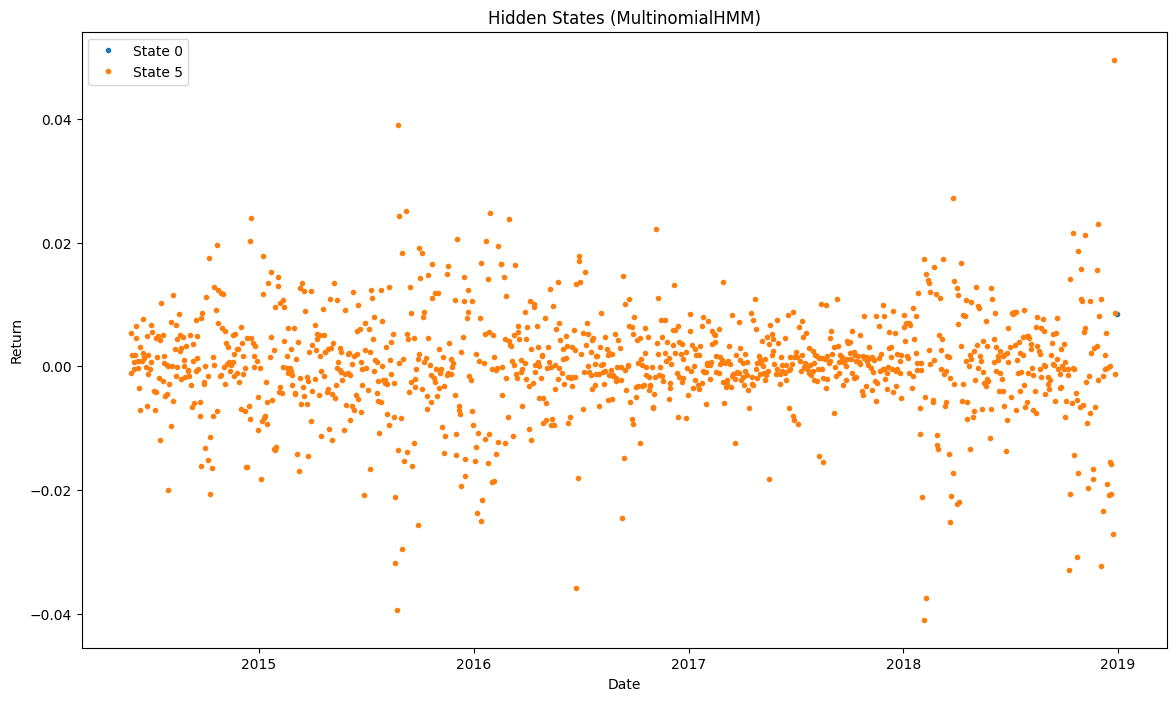

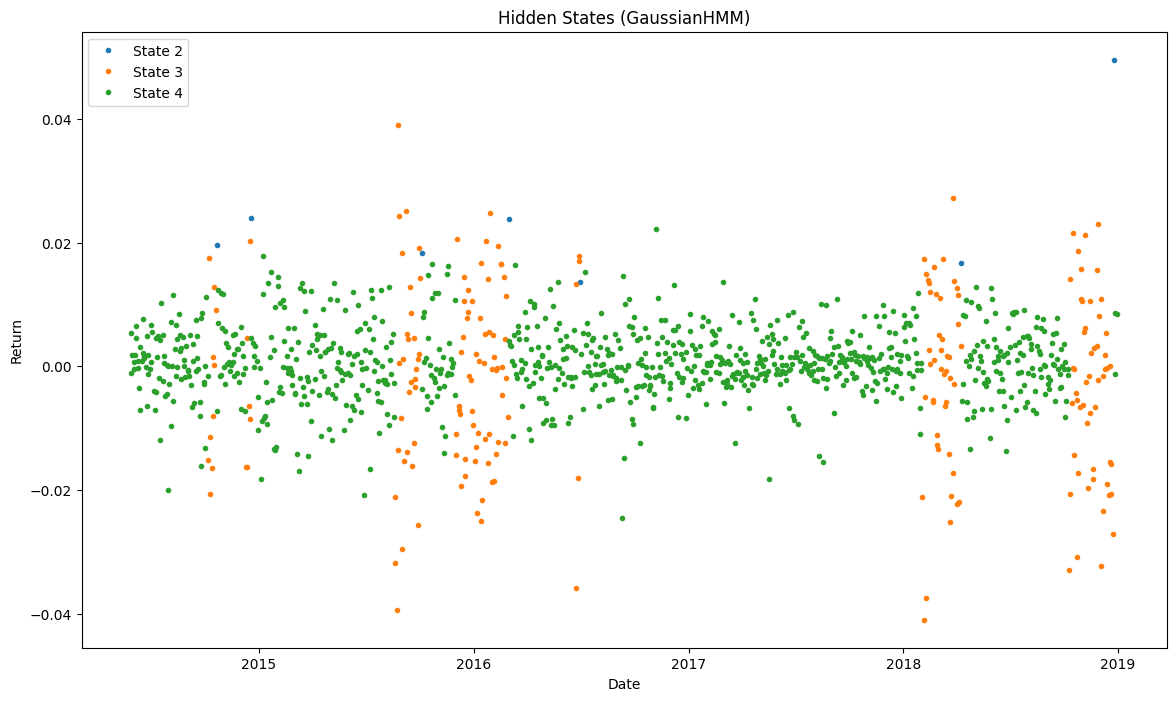

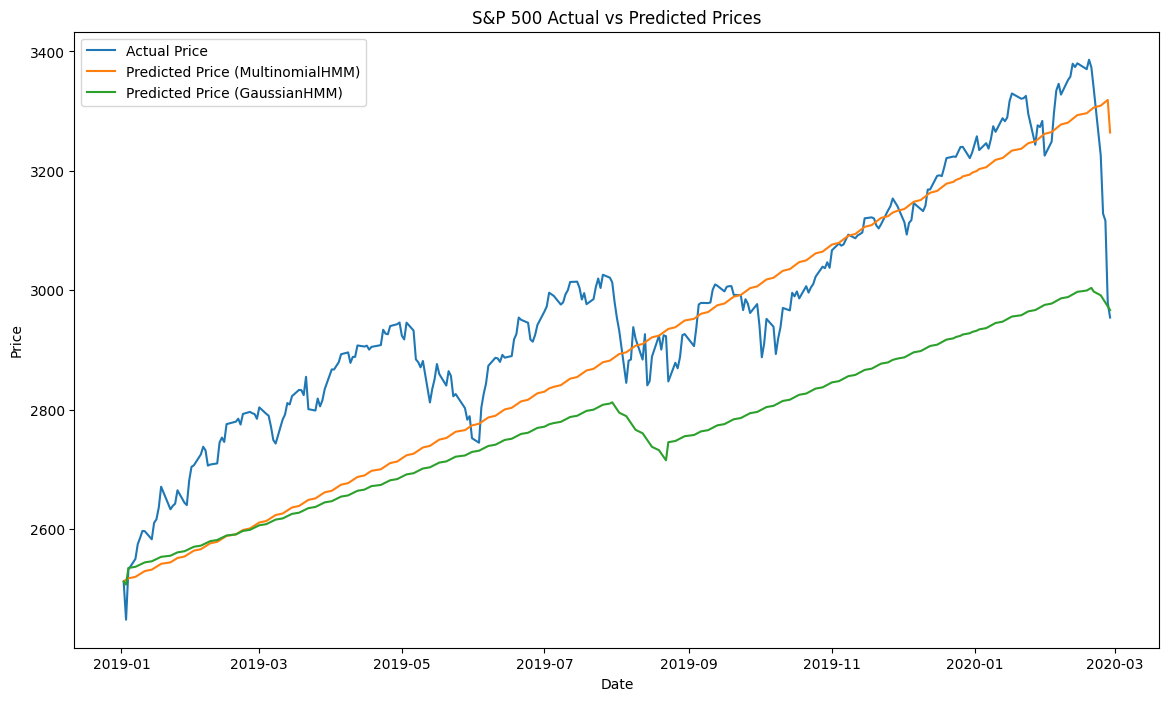

In [14]:
# Function to bucket returns
def bucket_return(x, n_buckets=10):
    # Create quantile buckets
    quantiles = np.linspace(0, 1, n_buckets + 1)
    bins = np.quantile(x.dropna(), quantiles)
    bins[0] = bins[0] - 1e-8  # Ensure the minimum value is included
    return np.digitize(x, bins) - 1

# Function to predict prices
def predict_prices(hmm, test_data, bucket_func, is_multinomial=True):
    if is_multinomial:
        test_buckets = bucket_func(test_data['return'])
        hidden_states = hmm.predict(test_buckets.reshape(-1, 1))
    else:
        hidden_states = hmm.predict(test_data['return'].values.reshape(-1, 1))
    
    # Reverse the transformation
    if is_multinomial:
        means = [train_data[train_data['bucket'] == i]['return'].mean() for i in range(10)]
        predicted_returns = [means[state] for state in hidden_states]
    else:
        predicted_returns = hmm.means_[hidden_states].flatten()
    
    # Compute the predicted prices
    predicted_prices = [test_data['sp500'].values[0]]
    for r in predicted_returns:
        predicted_prices.append(predicted_prices[-1] * (1 + r))
    
    return predicted_prices[1:]


# Separate the training and test data
X = sp500_df[sp500_df['date'] < '2020-03-01']
train_data = X[X['date'] < '2019-01-01']
print(train_data.columns)
test_data = X[X['date'] >= '2019-01-01']

# Apply bucketing to training data
train_data['bucket'] = bucket_return(train_data['return'])

# Prepare the data for HMM
X_train = train_data['bucket'].values.reshape(-1, 1)
X_train_gaussian = train_data['return'].values.reshape(-1, 1)

# Train MultinomialHMM
n_states = 6  # You can adjust the number of states
multi_hmm = MultinomialHMM(n_components=n_states, n_iter=1000, init_params='ste')
multi_hmm.fit(X_train)

# Ensure the probabilities are properly normalized
if not np.allclose(multi_hmm.startprob_.sum(), 1):
    multi_hmm.startprob_ = np.full(n_states, 1.0 / n_states)
if not np.allclose(multi_hmm.transmat_.sum(axis=1), 1):
    multi_hmm.transmat_ = np.full((n_states, n_states), 1.0 / n_states)

# Train GaussianHMM
gaussian_hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, init_params='ste')
gaussian_hmm.fit(X_train_gaussian)

# Ensure the probabilities are properly normalized
if not np.allclose(gaussian_hmm.startprob_.sum(), 1):
    gaussian_hmm.startprob_ = np.full(n_states, 1.0 / n_states)
if not np.allclose(gaussian_hmm.transmat_.sum(axis=1), 1):
    gaussian_hmm.transmat_ = np.full((n_states, n_states), 1.0 / n_states)

# Predict prices using both models
multi_predicted_prices = predict_prices(multi_hmm, test_data, bucket_return, is_multinomial=True)
gaussian_predicted_prices = predict_prices(gaussian_hmm, test_data, bucket_return, is_multinomial=False)

# Add the predictions to the test data
test_data['multi_predicted'] = multi_predicted_prices
test_data['gaussian_predicted'] = gaussian_predicted_prices

# Plot the hidden states for MultinomialHMM
def plot_hidden_states(df, hidden_states, title):
    plt.figure(figsize=(14, 8))
    for state in np.unique(hidden_states):
        state_mask = hidden_states == state
        plt.plot(df['date'][state_mask], df['return'][state_mask], '.', label=f'State {state}')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# Visualize hidden states for MultinomialHMM
hidden_states_multi = multi_hmm.predict(X_train)
plot_hidden_states(train_data, hidden_states_multi, 'Hidden States (MultinomialHMM)')

# Visualize hidden states for GaussianHMM
hidden_states_gaussian = gaussian_hmm.predict(X_train_gaussian)
plot_hidden_states(train_data, hidden_states_gaussian, 'Hidden States (GaussianHMM)')

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 8))
plt.plot(test_data['date'], test_data['sp500'], label='Actual Price')
plt.plot(test_data['date'], test_data['multi_predicted'], label='Predicted Price (MultinomialHMM)')
plt.plot(test_data['date'], test_data['gaussian_predicted'], label='Predicted Price (GaussianHMM)')
plt.title('S&P 500 Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


C:\Users\regin\AppData\Local\Temp\ipykernel_5196\3279283751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["combined"] = (test_data["multi_predicted"] + test_data["gaussian_predicted"])/2


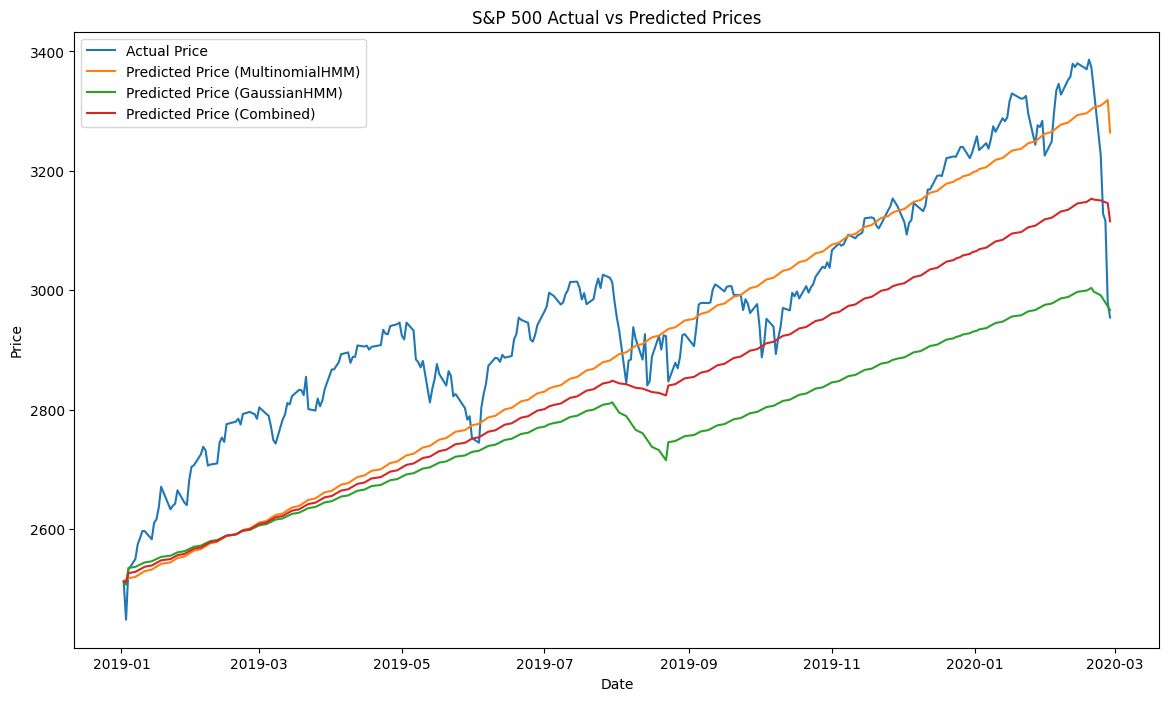

In [16]:
test_data["combined"] = (test_data["multi_predicted"] + test_data["gaussian_predicted"])/2
plt.figure(figsize=(14, 8))
plt.plot(test_data['date'], test_data['sp500'], label='Actual Price')
plt.plot(test_data['date'], test_data['multi_predicted'], label='Predicted Price (MultinomialHMM)')
plt.plot(test_data['date'], test_data['gaussian_predicted'], label='Predicted Price (GaussianHMM)')
plt.plot(test_data['date'], test_data['combined'], label='Predicted Price (Combined)')
plt.title('S&P 500 Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Rabiner Example

In [ ]:
import numpy as np
# Basic HMM from Rabiner 1989

# Symbols
V = ["rain", "cloudy", "sun",]
S = [1, 2, 3]

# number of observations
T = 8

# State distribution
pi = [0.5, 0.5]

# Transition matrix
A = [[0.7, 0.3],
     [0.3, 0.7]]
#_A = [0.4 0.3 0.3 0.2 0.6 0.2 0.1 0.1 0.8]
_A = [0.4, 0.3, 0.3, 0.2, 0.6, 0.2, 0.1, 0.1, 0.8]
A = np.array(_A).reshape(3,3)
print(A)

q_states = [3] # "sun"
for t in range(1, T):
    # Transition state
    current_state = q_states[t-1]
    transition_probs = A[current_state-1]
    print(t, transition_probs)
    state = np.random.choice(S, p=transition_probs)
    q_states.append(state)
q_states

In [ ]:
# get probability of a given sequence `y`
A = [[0.4, 0.3, 0.3], [0.2, 0.6, 0.2], [0.1, 0.1, 0.8]]
y = [3-1,3-1,3-1,1-1,1-1,3-1,2-1,3-1]
def sequence_prob(A, y, verbose=False):
    T = len(y)
    for t in range(T):
        if t==0:
            current_state = y[t]
            next_state = y[t+1]
            p = 1
            if verbose:
                print(f"t={t+1}, current_state={current_state+1}, next_state={next_state+1}, p={p}")
        else:
            next_state = y[t]
            p *= A[current_state][next_state]
            if verbose:
                print(f"t={t+1}, current_state={current_state+1}, next_state={next_state+1}, p={p}")
            current_state = next_state
    return p
sequence_prob(A, y, verbose=True)

In [ ]:
t, current_state, next_state